In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
df = pd.read_csv("../Data/NYCTaxiFares.csv")
df.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df.columns
df["dist_km"] = haversine_distance(df, "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude")

In [6]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [7]:
df["EDTdate"] = pd.to_datetime(df["pickup_datetime"].str[:19]) - pd.Timedelta(hours=4)

df["Hour"] = df["EDTdate"].dt.hour
df["AMorPM"] =  np.where(df["Hour"] > 12,  "pm", "am")
df["Weekday"] = df["EDTdate"].dt.strftime("%a")

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [8]:
df.columns
cat_cols = ["Hour", "AMorPM", "Weekday"]
cont_cols = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count", "dist_km"]
y_col = ["fare_amount"]

In [9]:
for cat in cat_cols:
    df[cat] = df[cat].astype("category")

In [10]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [11]:
df["Weekday"].cat.categories
df["Weekday"].cat.codes

0         1
1         2
2         2
3         3
4         0
         ..
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [12]:
hr = df["Hour"].cat.codes.values
ampm = df["AMorPM"].cat.codes.values
weekday = df["Weekday"].cat.codes.values

cats = np.stack([hr, ampm, weekday], 1)

# cats = np.stack([ df[cat].cat.codes.values for cat in cat_cols], 1)
cats = torch.tensor(cats, dtype=torch.int64)

cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  0,  2]])

In [13]:
conts = np.stack([ df[cont].values for cont in cont_cols], 1)

conts = torch.tensor(conts, dtype=torch.float)

conts[:5]

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        [-73.9905,  40.7564, -73.9712,  40.7482,   1.0000,   1.8641],
        [-73.9910,  40.7342, -73.9060,  40.7431,   1.0000,   7.2313]])

In [14]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [15]:
cats_szs = [len(df[cat].cat.categories) for cat in cat_cols]
cats_szs
emb_szs = [ ( size, min(50, (size+1)// 2)) for size in cats_szs]

emb_szs

[(24, 12), (2, 1), (7, 4)]

In [16]:
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [17]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [18]:
list(enumerate(selfembeds))
embeddingz = []

for i, e in enumerate(selfembeds):
    embeddingz.append(e(catz[:, i]))

embeddingz

[tensor([[-0.3725, -1.5101,  0.4947, -0.1977, -0.3848,  0.1636, -0.5073,  1.7408,
          -1.1316, -0.2060,  0.4712,  0.4223],
         [ 0.3078,  1.5484,  0.8866,  0.8184, -0.9955,  1.0579, -1.0038,  0.1986,
          -1.0156,  1.7340,  0.5610, -0.6845],
         [-0.2390, -0.6964, -0.0652,  0.2079, -0.5023,  0.3264, -0.2888,  0.1435,
          -1.4231, -0.6412,  0.2317, -0.1244],
         [ 0.7793,  0.4493,  0.6294, -0.1006,  0.3680, -1.4663, -0.6844, -1.1113,
           0.7152,  1.4492,  0.8558, -0.9463]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.3881],
         [-0.3881],
         [-0.3881],
         [-0.1715]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.9404, -1.6447,  0.5598,  0.2483],
         [-0.1589, -2.1711, -0.1696, -0.7023],
         [-0.1589, -2.1711, -0.1696, -0.7023],
         [ 1.5224,  1.1498, -0.6736, -1.8127]], grad_fn=<EmbeddingBackward0>)]

In [19]:
z = torch.cat(embeddingz, 1)
z

tensor([[-0.3725, -1.5101,  0.4947, -0.1977, -0.3848,  0.1636, -0.5073,  1.7408,
         -1.1316, -0.2060,  0.4712,  0.4223, -0.3881,  1.9404, -1.6447,  0.5598,
          0.2483],
        [ 0.3078,  1.5484,  0.8866,  0.8184, -0.9955,  1.0579, -1.0038,  0.1986,
         -1.0156,  1.7340,  0.5610, -0.6845, -0.3881, -0.1589, -2.1711, -0.1696,
         -0.7023],
        [-0.2390, -0.6964, -0.0652,  0.2079, -0.5023,  0.3264, -0.2888,  0.1435,
         -1.4231, -0.6412,  0.2317, -0.1244, -0.3881, -0.1589, -2.1711, -0.1696,
         -0.7023],
        [ 0.7793,  0.4493,  0.6294, -0.1006,  0.3680, -1.4663, -0.6844, -1.1113,
          0.7152,  1.4492,  0.8558, -0.9463, -0.1715,  1.5224,  1.1498, -0.6736,
         -1.8127]], grad_fn=<CatBackward0>)

In [26]:
class TabulerModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5 ):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum([ nf for ni, nf in emb_szs])
        n_in = n_emb + n_cont
        layerlist = []
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_sz))
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x


In [27]:
torch.manual_seed(33)

model = TabulerModel(emb_szs, conts.shape[-1], 1, [200, 100], p=0.4)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size - test_size]
cat_test = cats[batch_size - test_size : batch_size]

cont_train = conts[:batch_size - test_size]
cont_test = conts[batch_size - test_size : batch_size]

y_train = y[:batch_size - test_size]
y_test = y[batch_size - test_size : batch_size]

In [35]:
import time

start_time = time.time()

epochs = 326
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(cat_train, cont_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)

    if i%25 == 1:
        print(f"epoch: {i:3} loss: {loss.item(): 10.8f}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1 loss:  3.27560568
epoch:  26 loss:  3.25782752
epoch:  51 loss:  3.26402974
epoch:  76 loss:  3.24154377
epoch: 101 loss:  3.24913621
epoch: 126 loss:  3.24532986
epoch: 151 loss:  3.22439790
epoch: 176 loss:  3.19536591
epoch: 201 loss:  3.22298098
epoch: 226 loss:  3.22035122
epoch: 251 loss:  3.22130394
epoch: 276 loss:  3.20988083
epoch: 301 loss:  3.18429589
epoch: 326 loss:  3.20060921
epoch: 326  loss: 3.20060921

Duration: 48 seconds


Text(0.5, 0, 'epoch')

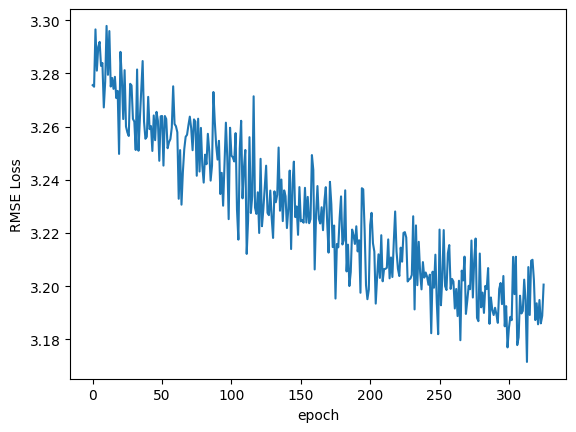

In [36]:
losses_np = [loss.detach().numpy() for loss in losses]
plt.plot(range(epochs), losses_np)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

In [37]:
with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_val , y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.12660980


In [38]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item() - y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   3.9933   2.9000   1.0933
 2.  21.0767   5.7000  15.3767
 3.   5.9408   7.7000   1.7592
 4.  12.0477  12.5000   0.4523
 5.   4.6246   4.1000   0.5246
 6.   5.8489   5.3000   0.5489
 7.   3.8603   3.7000   0.1603
 8.  17.4519  14.5000   2.9519
 9.   5.7253   5.7000   0.0253
10.   9.7015  10.1000   0.3985
11.   5.1728   4.5000   0.6728
12.   5.5843   6.1000   0.5157
13.   6.5509   6.9000   0.3491
14.  14.7715  14.1000   0.6715
15.   5.3754   4.5000   0.8754
16.  37.6837  34.1000   3.5837
17.   3.8656  12.5000   8.6344
18.   4.3461   4.1000   0.2461
19.   9.1913   8.5000   0.6913
20.   5.4038   5.3000   0.1038
21.  11.7120  11.3000   0.4120
22.  13.0050  10.5000   2.5050
23.  15.5239  15.3000   0.2239
24.  16.8318  14.9000   1.9318
25.  47.5484  49.5700   2.0216
26.   6.2282   5.3000   0.9282
27.   5.6524   3.7000   1.9524
28.   8.1527   6.5000   1.6527
29.  15.8233  14.1000   1.7233
30.   7.1510   4.9000   2.2510
31.   5.3353   3.7000   1.6353
32.  43.

In [ ]:
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model hasnot been trained yet.')